In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from src.Simulator.SSA import SSASimulator
import numpy as np
from src.Estimation.NN import CTMCKerasModel
from src.Estimation.NN import getTrainDatasetFromSimulations
from src.Models.utils import getReactionsForObservations
from src.Estimation.utils import createPropensityPlot
from src.Estimation.MLE import MLEstimator

# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [13]:
from src.Models.models import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
y, t = simulator_bd.run_ssa(np.array([5]), 1000, parameters)
num_states = y.shape[1]

We set up the NN model

In [15]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = CTMCKerasModel(num_inputs = num_states, num_outputs=num_unique_stoch, num_layers=2, num_neurons=8)
train_dataset = getTrainDatasetFromSimulations(y, t, reaction_indices)

We train the model on the training data

In [17]:
custom_model.fit(train_dataset, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 63ms/step - loss: 246.3037
Epoch 2/100
8/8 [==============================] - 0s 57ms/step - loss: 246.1718
Epoch 3/100
8/8 [==============================] - 0s 53ms/step - loss: 246.0537
Epoch 4/100
8/8 [==============================] - 0s 54ms/step - loss: 245.9713
Epoch 5/100
8/8 [==============================] - 0s 55ms/step - loss: 245.8889
Epoch 6/100
8/8 [==============================] - 0s 56ms/step - loss: 245.7935
Epoch 7/100
8/8 [==============================] - 0s 56ms/step - loss: 245.6940
Epoch 8/100
8/8 [==============================] - 0s 55ms/step - loss: 245.5984
Epoch 9/100
8/8 [==============================] - 0s 54ms/step - loss: 245.5047
Epoch 10/100
8/8 [==============================] - 0s 55ms/step - loss: 245.4131
Epoch 11/100
8/8 [==============================] - 0s 55ms/step - loss: 245.3223
Epoch 12/100
8/8 [==============================] - 0s 53ms/step - loss: 245.2319
Epoch 13/100
8/8 [=======

We plot the estimation results

62/62 [==============================] - 0s 1ms/step


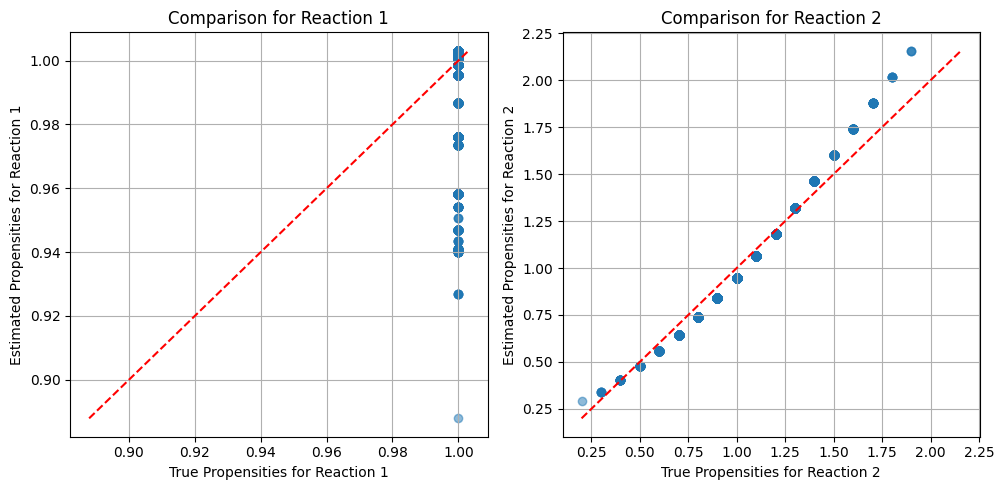

In [18]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Lets compare it with the MLE 

/tmp/ipykernel_76962/653699787.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


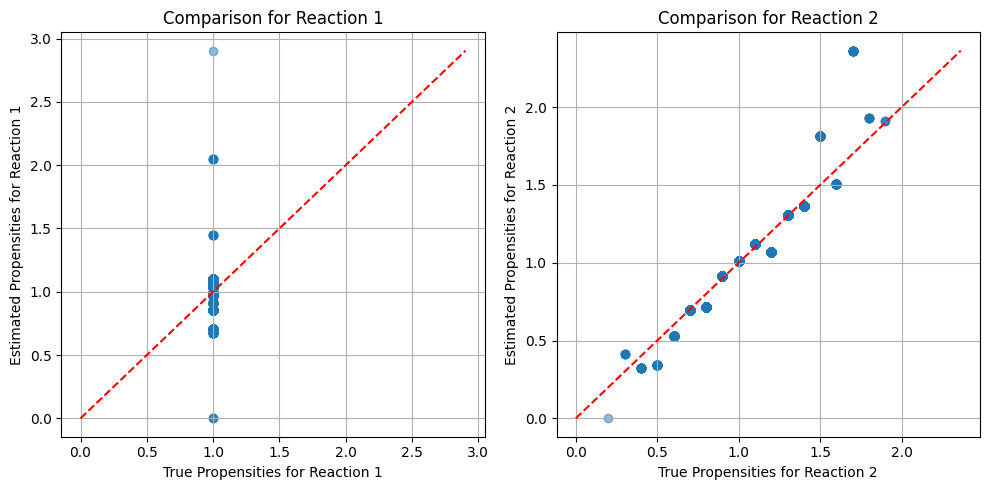

In [19]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# NN for Lotka-Voltera Model

In [20]:
from src.Models.models import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
y, t = simulator_lv.run_ssa(np.array([80000, 10, 10]), 1000, parameters)
num_states = y.shape[1]

In [21]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = CTMCKerasModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=5, num_neurons=128)
train_dataset = getTrainDatasetFromSimulations(y, t, reaction_indices, batch_size=256)

In [22]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
128/128 [==============================] - 9s 62ms/step - loss: 22223.7617
Epoch 2/200
128/128 [==============================] - 9s 67ms/step - loss: -105.8842
Epoch 3/200
 13/128 [==>...........................] - ETA: 8s - loss: -127.7512

KeyboardInterrupt: 

1019/1019 [==============================] - 2s 2ms/step
Mean Squared Error between NN predictions and expected propensities: 4.979222657662776


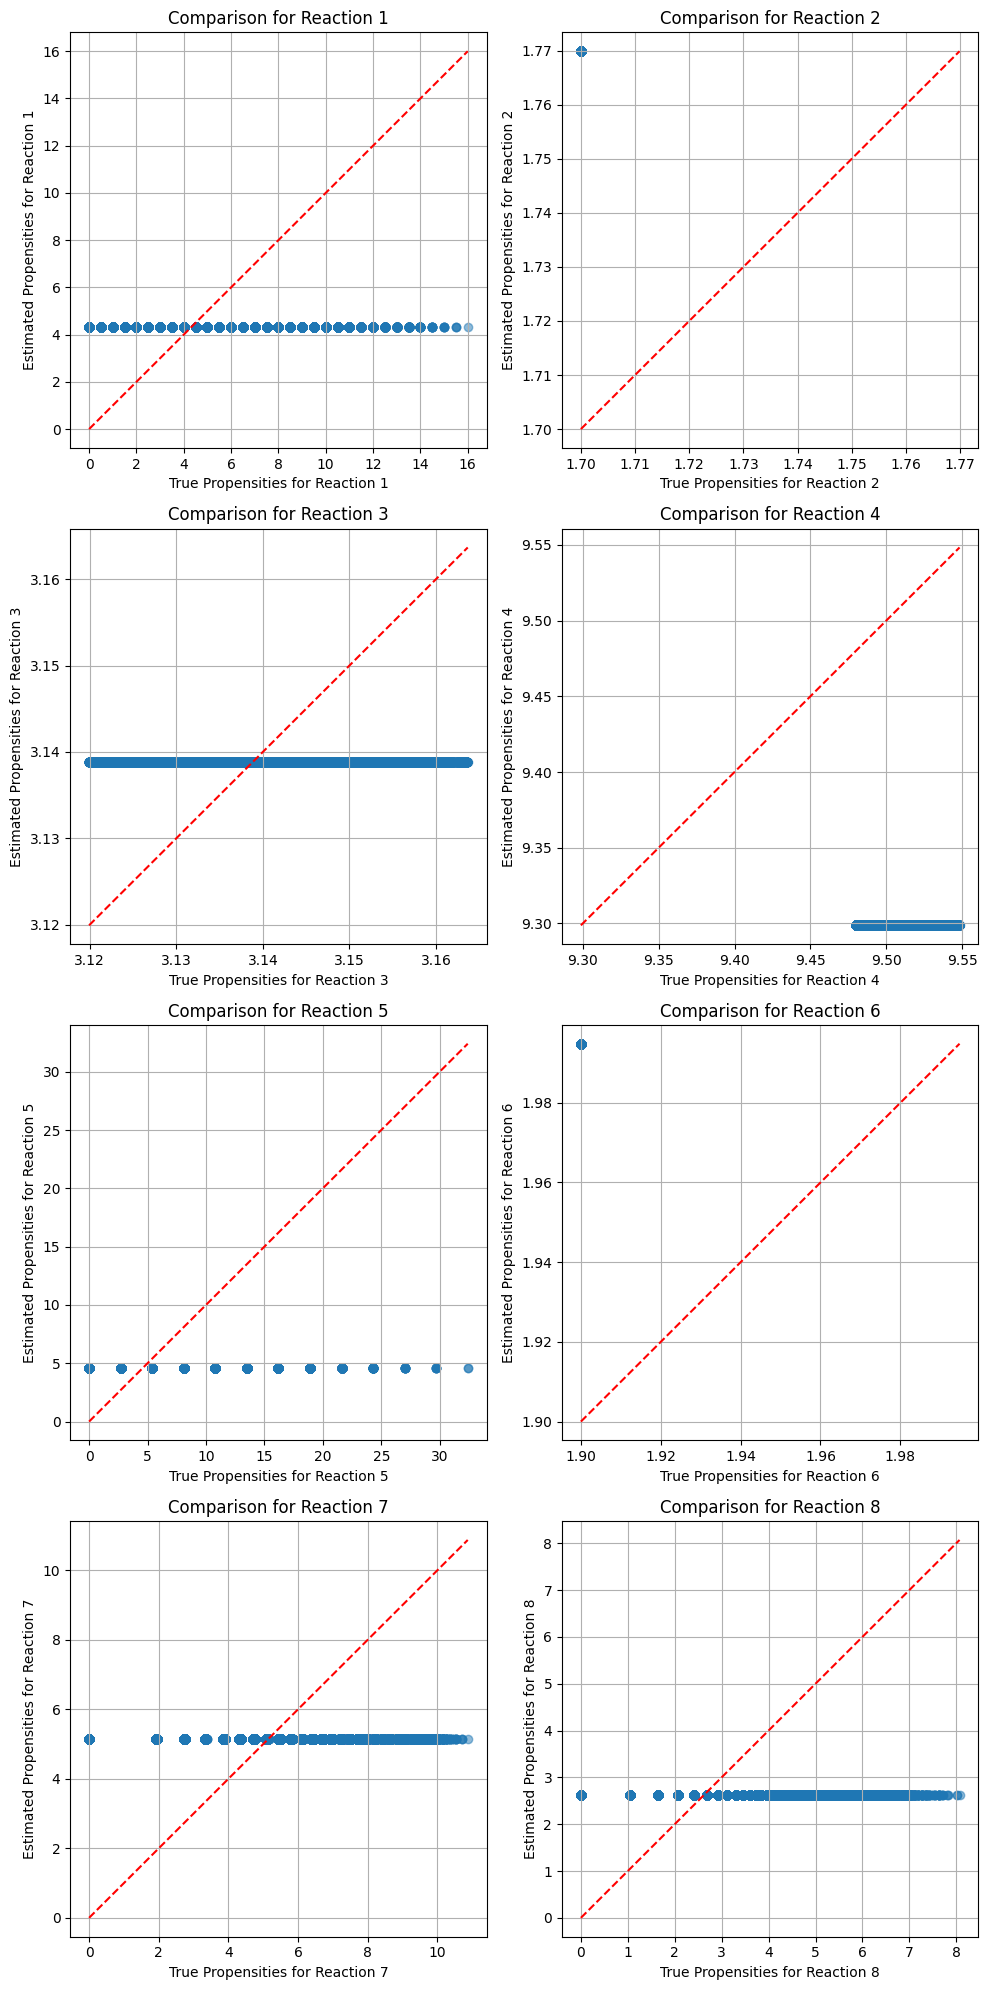

In [48]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
fig = createPropensityPlot(nn_predictions, true_props_unique)

# NN for Chemical Reaction Network Model


In [23]:
from src.Models.models import ChemicalReactionNetwork
model_crn = ChemicalReactionNetwork()
simulator_crn = SSASimulator(model_crn)

parameters = model_crn.getDefaultParameter()
y, t = simulator_crn.run_ssa(np.array([1, 3]), 10000, parameters)
num_states = y.shape[1]

In [24]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_crn.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = CTMCKerasModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=4)
train_dataset = getTrainDatasetFromSimulations(y, t, reaction_indices, batch_size=512)

In [25]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
6/6 [==============================] - 2s 90ms/step - loss: 2571.0212
Epoch 2/200
6/6 [==============================] - 1s 92ms/step - loss: 2014.8027
Epoch 3/200
6/6 [==============================] - 1s 95ms/step - loss: 1918.7826
Epoch 4/200
6/6 [==============================] - 1s 93ms/step - loss: 1721.9321
Epoch 5/200
6/6 [==============================] - 1s 96ms/step - loss: 1657.2675
Epoch 6/200
6/6 [==============================] - 1s 96ms/step - loss: 1588.9603
Epoch 7/200
6/6 [==============================] - 1s 97ms/step - loss: 1553.8173
Epoch 8/200
6/6 [==============================] - 1s 98ms/step - loss: 1527.2743
Epoch 9/200
6/6 [==============================] - 1s 96ms/step - loss: 1513.4131
Epoch 10/200
6/6 [==============================] - 1s 98ms/step - loss: 1499.8571
Epoch 11/200
6/6 [==============================] - 1s 98ms/step - loss: 1491.7344
Epoch 12/200
6/6 [==============================] - 1s 97ms/step - loss: 1483.0953
Epoch 13/200


81/81 [==============================] - 0s 2ms/step


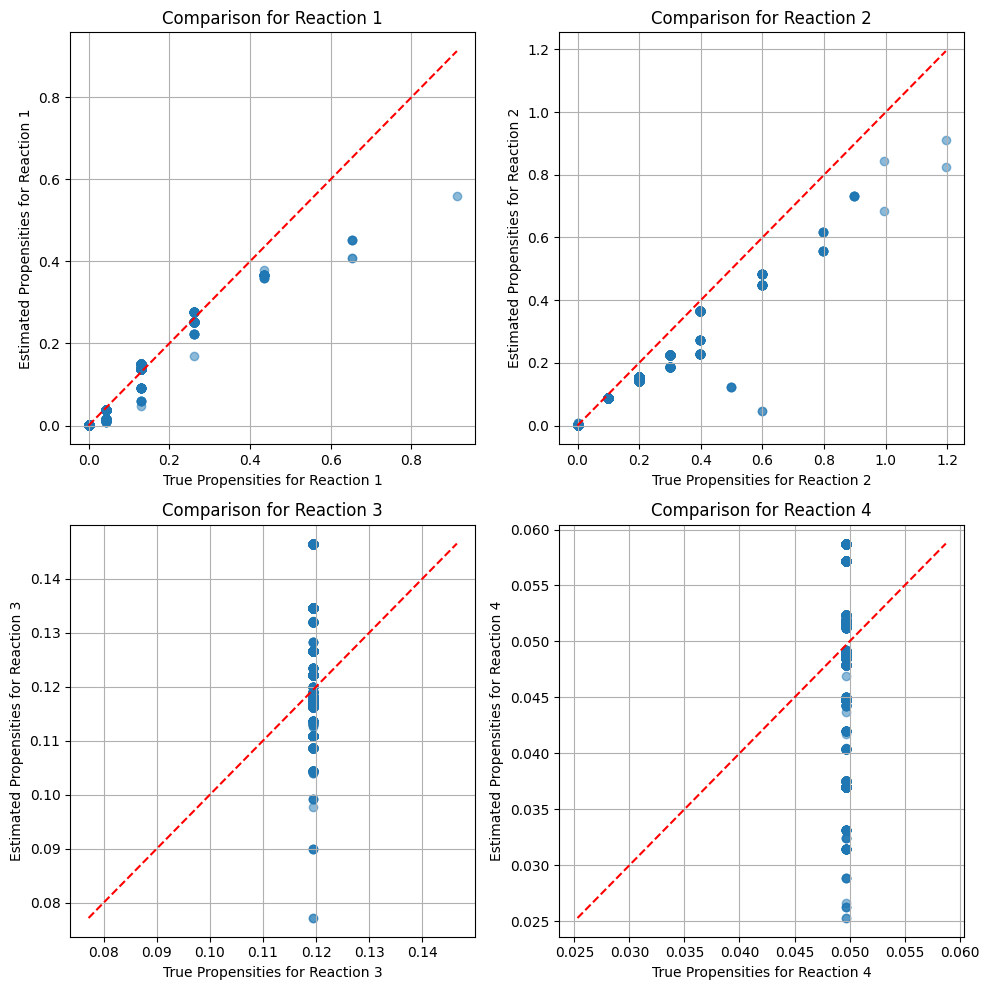

In [26]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_crn.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Compare with NLE

/tmp/ipykernel_76962/13457184.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


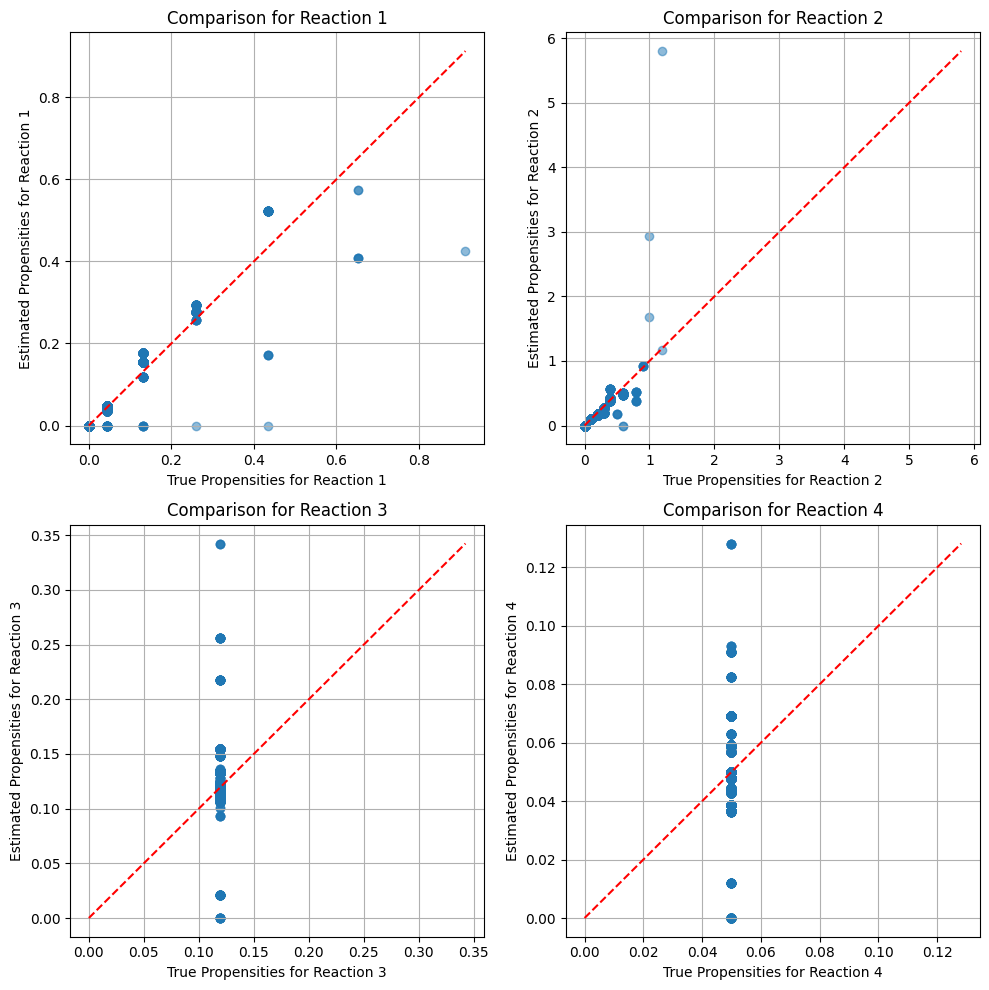

In [27]:
estimator = MLEstimator(model_crn, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()